# Improving Lung Imaging with AI

You can use this notebook for inference. The downsampled and original resolved data can be found under the following links:

1. downsampled dataset: https://cloud.rz.uni-kiel.de/index.php/s/bnkfFKyQjP45bFd
2. downsampled dataset but same size as the original: https://cloud.rz.uni-kiel.de/index.php/s/B8iKkgcaNkLNo8c
3. original dataset: https://cloud.rz.uni-kiel.de/index.php/s/NN49Ys5b6t4DcKH

**When entering the Challenge you accept the TCIA Data Usage Policy https://wiki.cancerimagingarchive.net/display/Public/Data+Usage+Policies+and+Restrictions and the Creative Commons Attribution 3.0 Creative Commons Attribution 3.0 Unported License https://wiki.cancerimagingarchive.net/display/Public/LIDC-IDRI#1966254a2b592e6fba14f949f6e23bb1b7804cc**

In [6]:
#for colab users only - mounting the drive 
from google.colab import drive
drive.mount('/content/drive',force_remount = False)

#setup a base directory where everything will be installed - repo, dataset, libraries
#This .ipynb notebook needs to placed there as well.
import os
import torch
base_dir = '/content/drive/My Drive/Colab Notebooks'
os.chdir(base_dir)

ModuleNotFoundError: No module named 'google'

In [1]:
# Only for local users
import os
import torch

# The location where the hackathon data will be stored
base_dir = '/home/sukin707/hackathon'
os.chdir(base_dir)

In [2]:
!ls

data  lung_imaging  results


In [ ]:
!wget -O down_sampled_samesize.zip  https://cloud.rz.uni-kiel.de/index.php/s/B8iKkgcaNkLNo8c/download
!unzip down_sampled_samesize.zip
!rm -r down_sampled_samesize.zip

In [ ]:
!wget -O original_set.zip  https://cloud.rz.uni-kiel.de/index.php/s/NN49Ys5b6t4DcKH/download
!unzip original_set.zip
!rm -r original_set.zip

## Imports

In [2]:
!git clone https://github.com/nkoser/lung_imaging.git

Cloning into 'lung_imaging'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 19 (delta 6), reused 15 (delta 5), pack-reused 0
Unpacking objects: 100% (19/19), done.


In [3]:
os.chdir(os.path.join(base_dir,'lung_imaging'))

In [39]:
!pip install git+https://github.com/jinh0park/pytorch-ssim-3D.git
!pip install pkbar

  Cloning https://github.com/jinh0park/pytorch-ssim-3D.git to /tmp/pip-req-build-sr35yv3k
  Running command git clone --filter=blob:none -q https://github.com/jinh0park/pytorch-ssim-3D.git /tmp/pip-req-build-sr35yv3k
  Resolved https://github.com/jinh0park/pytorch-ssim-3D.git to commit ada88564a754cd857730d649c511384dd41f9b4e
  Preparing metadata (setup.py) ... done


In [4]:
!nvidia-smi

Wed Jun  8 23:55:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:1A:00.0 Off |                    0 |
| N/A   35C    P0    56W / 300W |   1282MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:1B:00.0 Off |                    0 |
| N/A   

In [41]:
!export CUDA_VISIBLE_DEVICES=7

In [42]:
!mkdir /home/sukin707/hackathon/results

mkdir: cannot create directory ‘/home/sukin707/hackathon/results’: File exists


In [5]:
import os
from glob import glob
import matplotlib.pyplot as plt
import pkbar as pkbar
import torch
from torch import nn
from torch.utils.data import DataLoader
import pandas as pd
from data_loader import Lung_patch_loader, Lung_loader
from resUnet import ResUnet3D
import pytorch_ssim

from utils import PSNR

In [6]:
down_img_paths = glob(os.path.join(base_dir,'data','down_samesize','Training', '*.nii.gz'))
down_img_paths.sort()
org_img_paths = glob(os.path.join(base_dir,'data','Original','Training', '*.nii.gz'))
org_img_paths.sort()


In [7]:
!rm -r results
!mkdir results

rm: cannot remove 'results': No such file or directory


In [9]:
exp_name = 'test_I'
folder_path = os.path.join(base_dir,'results')

## Define Training Loader

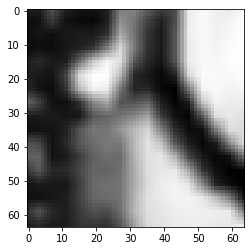

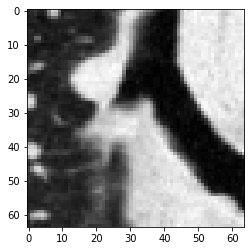

In [9]:
train_set = Lung_patch_loader(down_img_paths[:30], org_img_paths[:30])
val_set = Lung_patch_loader(down_img_paths[30:], org_img_paths[30:])

imgs = val_set[0]

plt.imshow(imgs[0][0, :, 32, :].cpu().rot90().numpy(), 'gray')
plt.show()

plt.imshow(imgs[1][0, :, 32, :].cpu().rot90().numpy(), 'gray')
plt.show()

train_loader = DataLoader(train_set, batch_size=1, shuffle=True)
val_loader = DataLoader(val_set, batch_size=1, shuffle=True)

In [10]:
model = ResUnet3D(channel=1).cuda()

torch.manual_seed(101)

nr_epx = 25

# initialize the optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.95)
criterion = nn.MSELoss()

run_loss = 0
run_acc = 0

# Save loss of each epoch
losses_training = []
losses_validate = []
psnrs = []
ssims = []

iterate = len(train_loader)
bar = pkbar.Pbar(name="Progress", target=iterate)
best_ssim = 0

Progress


## Training and Validation

In [11]:
for epoch in range(nr_epx):

    ########################################
    #               TRAINING               #
    ########################################

    sum_loss = 0

    # Parameters must be trainable
    model.train()
    with torch.set_grad_enabled(True):
        print(f"{20 * '-'} Epoche: {epoch + 1} {20 * '-'}")
        # loop to process all training samples (packed into batches)
        for batch_ndx, (x, y) in enumerate(train_loader):
            optimizer.zero_grad()
            x, y = x.float().cuda(), y.float().cuda()
            pred = model(x)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()
            bar.update(batch_ndx)
            print(x.min(),x.max())

        losses_training.append(sum_loss / len(train_loader))

    ########################################
    #              VALIDATION              #
    ########################################

    sum_loss, psnr_sum, ssim_sum = 0, 0, 0

    # Parameters must not be trainable
    model.eval()
    with torch.set_grad_enabled(False):  # TODO add bool value

        for batch_ndx, (x, y) in enumerate(val_loader):
            x, y = x.float().cuda(), y.float().cuda()
            # print(f"Size: {x.shape}")
            pred = model(x)
            predicted = torch.argmax(pred)
            loss = criterion(pred, y)
            sum_loss += loss.item()
            psnr_sum += PSNR()(pred, y).item()
            ssim_sum += pytorch_ssim.ssim3D(pred, y).item()
        losses_validate.append(sum_loss / len(val_loader))
        ssims.append(ssim_sum / len(val_loader))
        psnrs.append(psnr_sum / len(val_loader))

        if ssims[-1] > best_ssim:
            print(f" Best Validation SSIM: {ssims[-1]}")
            best_ssim = ssims[-1]
            torch.save(model, os.path.join(folder_path, exp_name + "best.pth"))
        print(f"Epoche {epoch} -- Trainings Loss {losses_training[-1]}")
        print(f"Epoche {epoch} -- Validation Loss {losses_validate[-1]}")
        print(f"Epoche {epoch} -- Validation PSNR {psnrs[-1]}")
        print(f"Epoche {epoch} -- Validation SSIM {ssims[-1]}")

torch.save(model, os.path.join(folder_path, exp_name + ".pth"))
df = pd.DataFrame([losses_validate, losses_training, psnrs, ssims])
df = (df.transpose())
df.columns = ["Validation", "Training", "PSNR", "SSIM"]
df.to_csv(os.path.join(folder_path, "val_loss.csv"))

-------------------- Epoche: 1 --------------------
30/30  [==============================] - 138.4s
tensor(0.0344, device='cuda:0') tensor(0.5038, device='cuda:0')
 Best Validation SSIM: 0.32901444286108017
Epoche 0 -- Trainings Loss 0.1990471171370397
Epoche 0 -- Validation Loss 0.03784428909420967
Epoche 0 -- Validation PSNR 14.278109073638916
Epoche 0 -- Validation SSIM 0.32901444286108017
-------------------- Epoche: 2 --------------------
30/30  [==============================] - 280.1s
tensor(0.0460, device='cuda:0') tensor(0.7023, device='cuda:0')
 Best Validation SSIM: 0.5820855796337128
Epoche 1 -- Trainings Loss 0.0266214362035195
Epoche 1 -- Validation Loss 0.009853789932094514
Epoche 1 -- Validation PSNR 20.866758823394775
Epoche 1 -- Validation SSIM 0.5820855796337128
-------------------- Epoche: 3 --------------------
30/30  [==============================] - 420.6s
tensor(0.0174, device='cuda:0') tensor(0.6648, device='cuda:0')
Epoche 2 -- Trainings Loss 0.0209004498086

In [7]:
#!pip install batchgenerators
from sliding_window import predict_3D
from data_loader import Lung_loader, normalizeVolumes

     |████████████████████████████████| 61 kB 812 kB/s             
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 829 kB 2.1 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 12.4 MB 991 kB/s            
     |████████████████████████████████| 22.2 MB 342 kB/s            
     |████████████████████████████████| 25.9 MB 2.2 MB/s            
     |████████████████████████████████| 96 kB 302 kB/s             
     |████████████████████████████████| 148 kB 1.1 MB/s            
     |████████████████████████████████| 4.4 MB 81.6 MB/s            
     |████████████████████████████████| 3.3 MB 2.6 MB/s            
     |████████████████████████████████| 1.6 MB 5.4 MB/s            
     |████████████████████████████████| 306 kB 7.3 MB/s            
Using legacy 'setup.py install' for batchgenerators, since package 'wheel' is not installed.
Using legacy 'setup.py install' for future, since package 'wheel' is not 

In [28]:
# prediction
!pip install SimpleITK
import SimpleITK as sitk

exp_name = 'test_I'
psnr_list = []
ssims = []
names = []

# Loading model
gen = torch.load(os.path.join(folder_path, exp_name+ "best.pth"))
gen.eval()


down_img_paths = glob(os.path.join(base_dir,'data','down_samesize','Test_t', '*.nii.gz'))
down_img_paths.sort()

org_img_paths = glob(os.path.join(base_dir,'data','Original','t_Test', '*.nii.gz'))
org_img_paths.sort()

test_set = Lung_loader(down_img_paths, org_img_paths)


for nr_batch,(x,y) in enumerate(test_set):
    
    x = x.float().cuda()
    y = y.float().cuda()

    org_patches, t, rec_img, nb_pred = predict_3D(x=x,
                                              patch_size=(64, 64, 64),
                                              use_gaussian=False,
                                              step_size=0.8, gen=gen.cuda())
    nb_pred = torch.tensor(nb_pred).unsqueeze(0).cpu()
    rec_img = torch.tensor(rec_img).cpu()
    rec_img = rec_img / nb_pred

    r = normalizeVolumes(rec_img)
    print(rec_img.shape)

    #ssims.append(pytorch_ssim.ssim3D(rec_img.cuda(), y.cpu()).cuda()).item()
    #psnr = PSNR()(rec_img.cuda(), y.cpu()).cuda()
 #   psnr_list.append(psnr.item())
#
   # print(f"\n PSNR: {psnr}")
  #  print(f"\n SSIM: {ssims[-1]}")
    
    itk_image = sitk.GetImageFromArray(rec_img[0, 0].cpu().numpy())
    sitk.WriteImage(itk_image, os.path.join(folder_path, f'test_{nr_batch}.nii.gz'))

step_size: 0.8
data shape: torch.Size([1, 238, 176, 110])
patch size: (64, 64, 64)
steps (x, y, and z): [[0, 44, 87, 130, 174], [0, 37, 75, 112], [0, 46]]
number of tiles: 40
Progress
40/40  [==============================] - 4.1s
(slice(0, 1, None), slice(0, 238, None), slice(0, 176, None), slice(0, 110, None))
torch.Size([1, 1, 238, 176, 110])
step_size: 0.8
data shape: torch.Size([1, 318, 217, 242])
patch size: (64, 64, 64)
steps (x, y, and z): [[0, 51, 102, 152, 203, 254], [0, 51, 102, 153], [0, 44, 89, 134, 178]]
number of tiles: 120
Progress
120/120  [==============================] - 12.0s
(slice(0, 1, None), slice(0, 318, None), slice(0, 217, None), slice(0, 242, None))
torch.Size([1, 1, 318, 217, 242])
step_size: 0.8
data shape: torch.Size([1, 236, 203, 260])
patch size: (64, 64, 64)
steps (x, y, and z): [[0, 43, 86, 129, 172], [0, 46, 93, 139], [0, 49, 98, 147, 196]]
number of tiles: 100
Progress
100/100  [==============================] - 10.0s
(slice(0, 1, None), slice(0, 2